In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json
from bson import json_util, ObjectId
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.rslp import RSLPStemmer
from nltk.cluster.util import cosine_distance
from re import *
from collections import Counter
import networkx as nx
import cProfile
import bokeh
from gensim import corpora, models, similarities
from string import punctuation
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import AffinityPropagation, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.manifold import TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
with open('/home/elisa/Documents/Projetos/TCC/data/articles_data/charliehebdo.json') as f:
    a = f.read()
    data = json_util.loads(a)
    

In [6]:
len(data)

2136

##Criação Matriz de Documentos

###Matriz TF-IDF

In [7]:
# gerador de palavras
ids=[]
def doc_gen(data):
    stopw = stopwords.words('portuguese') +['']
    for doc in data:
        try:
            list_words= nltk.tokenize.wordpunct_tokenize(doc['cleaned_text'])
            ids.append(doc['_id'])
        except KeyError:
            continue
        important_words = [word.lower().strip().strip(punctuation) for word in list_words if word.lower().strip().strip(punctuation) not in stopw]
        yield important_words

In [8]:
# gerador de frase
def sentence_gen(data):
    """
    Carrega as frases da coleção local para treinamento do modelo do W2v
    :return:
    """
    sw = stopwords.words('portuguese') +['']
    for doc in data:
        try:
            doc = nltk.tokenize.sent_tokenize(doc['cleaned_text'])
        except KeyError:
            continue
        for frase in doc:
            if frase == []:
                continue
            frase = [w.lower().strip(punctuation) for w in frase if w.strip(punctuation).lower() not in sw]
            if frase == []:
                continue
            # print(frase)
            # print(type(frase[0]))
            yield frase

In [9]:
# corpora gensim com todas as palavras, dictionary[id] retorna a palavra referente ao id
dictionary = corpora.Dictionary(doc_gen(data))

In [10]:
len(ids)

2122

In [11]:
# lista de documentos, cada documento é uma lista de tuplas onde documento[0] é uma tupla com id e quantidade da
# palavra no documento
corpus = [dictionary.doc2bow(text) for text in doc_gen(data)]

In [12]:
# matriz tfidf, onde cada pos é um documento
tfidf = models.TfidfModel(corpus)


###Matriz Word2Vec

In [19]:
#carrega o modelo word2vec para o mediacloud (possui todas as palavras do banco do mediacloud)
model= Word2Vec.load('/home/elisa/Documents/Projetos/TCC/Models/MediaCloud_w2v')

In [21]:
#constrói matriz de documentos. Cada linha da matriz é um documento
docvs = np.zeros((len(corpus), model.syn0.shape[1]), dtype=float)
for n,doc in enumerate(corpus):
    ti = dict(tfidf[doc])
    for word in doc:
        w = dictionary[word[0]]
        try:
            word_vector = model[w]
            try:
                assert np.isfinite(word_vector).all()
            except AssertionError:
                print (w)
        except KeyError:
            word_vector = np.zeros((1,model.syn0.shape[1]))
#             print('pulei ', w)
#         word_vector.shape = 1, model.syn0.shape[1]
        docvs[n,:] = docvs[n,:] + word_vector*ti[word[0]]
    

In [22]:
docvs

array([[ -2.67688062e-01,   6.90553774e-02,  -6.63830934e-01, ...,
          4.30988028e-01,   1.63781038e-01,   3.66105394e-01],
       [ -3.67950398e-01,   7.68701726e-03,  -6.83556589e-01, ...,
          2.57774762e-01,   4.44993938e-01,  -1.02725542e-01],
       [ -3.30171110e-01,   4.39305266e-02,  -6.52190350e-03, ...,
          2.60630530e-01,  -1.29768090e-04,  -2.49850826e-01],
       ..., 
       [ -6.91428823e-01,   3.55613570e-01,  -6.92535194e-01, ...,
          5.48758399e-01,  -3.79273088e-01,   6.26339498e-01],
       [ -9.98241114e-02,  -2.42660665e-02,   1.38597539e-01, ...,
          3.57703309e-01,  -1.72089929e-01,   1.14452985e-01],
       [ -4.41454657e-01,  -3.99939490e-02,  -4.90580054e-01, ...,
          1.28284194e-01,   6.16208572e-02,   5.87289029e-02]])

###Cluster

In [23]:
def cluster_vectors(docvs, method='DBS'):
    print("Calculating Clusters.")
    X = docvs
    if method == 'AP':
        af = AffinityPropagation(copy=False).fit(X)
        cluster_centers_indices = af.cluster_centers_indices_
        labels = af.labels_
        n_clusters_ = len(set(labels))
    elif method == 'DBS':
        print("Computing DBSCAN")
        db = DBSCAN(eps=0.03, min_samples=5, algorithm='brute', metric='cosine').fit(X)
        labels = db.labels_
        n_clusters_ = len(set(labels))
    elif method == 'AC':
        print("Computing Agglomerative Clustering")
        ac = AgglomerativeClustering(10).fit(X)
        labels = ac.labels_
        n_clusters_ = ac.n_clusters
    elif method == 'KM':
        print("Computing MiniBatchKmeans clustering")
        km = MiniBatchKMeans(n_clusters=300, batch_size=200).fit(X)
        labels = km.labels_
        n_clusters_ = len(km.cluster_centers_)

    print('Estimated number of clusters: %d' % n_clusters_)
    # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    # print("Adjusted Rand Index: %0.3f"
    # % metrics.adjusted_rand_score(labels_true, labels))
    # print("Adjusted Mutual Information: %0.3f"
    #       % metrics.adjusted_mutual_info_score(labels_true, labels))
    # print("Silhouette Coefficient: %0.3f"
    #       % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

    return X, labels

In [24]:
X, labels = cluster_vectors(docvs, "DBS")

Calculating Clusters.
Computing DBSCAN
Estimated number of clusters: 8


In [35]:
c=0
for i in labels:
    if i == -1:
        c+=1

In [36]:
c

2061

In [71]:
def consulta(id,data):
    for i in data:
        if i['_id'] == id:
            return i
def extract_clustered_docs(ids, labels, cluster_label):
    docs = []
    for i, l in zip(ids, labels):
        if l !=cluster_label:
            continue
        d = consulta(i,data)
        docs.append(d["_id"])
    return docs

In [38]:
a = extract_clustered_docs(ids,labels,29)

In [33]:
a   

[]

###TSNE Representation

In [28]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [29]:
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(docvs)

In [30]:
X_reduced.shape

(2122, 50)

In [31]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2122
[t-SNE] Computed conditional probabilities for sample 2000 / 2122
[t-SNE] Computed conditional probabilities for sample 2122 / 2122
[t-SNE] Mean sigma: 1.643471
[t-SNE] Iteration 10: error = 22.5737860, gradient norm = 0.0782115
[t-SNE] Iteration 20: error = 20.2072484, gradient norm = 0.0760214
[t-SNE] Iteration 30: error = 19.0988625, gradient norm = 0.0737031
[t-SNE] Iteration 40: error = 19.0307754, gradient norm = 0.0711873
[t-SNE] Iteration 50: error = 19.1123496, gradient norm = 0.0683755
[t-SNE] Iteration 60: error = 18.3075432, gradient norm = 0.0791071
[t-SNE] Iteration 70: error = 18.6462846, gradient norm = 0.0739666
[t-SNE] Iteration 80: error = 18.3788064, gradient norm = 0.0714583
[t-SNE] Iteration 83: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 83 iterations with early exaggeration: 18.459556
[t-SNE] Iteration 90: error = 2.1

In [32]:
X_embedded.shape

(2122, 2)

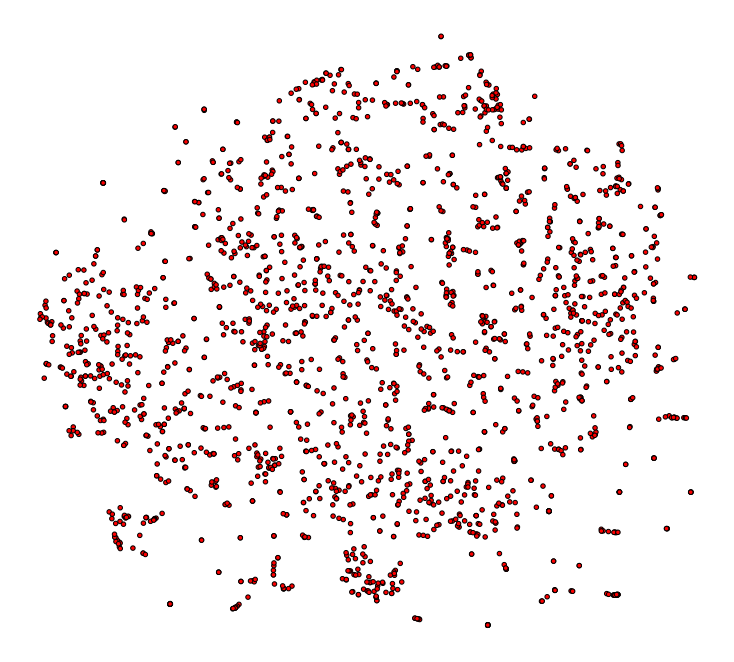

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['red'])
plt.show()

In [ ]:
X_pca = PCA().fit_transform(docvs)